# Empirical, anecdotal analysis of `mainnnet` mempool consistency

**<font color="red">PRELIMINARY, PARTIAL DRAFT: WORK IN PROGRESS</font>**

## Set up

In [1]:
suppressMessages({
    require(RColorBrewer, quietly=TRUE)
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
})

## Hourly summary

In [2]:
mempoolHourly <- fread("mempool-hourly.tsv.gz", stringsAsFactors=TRUE)
colnames(mempoolHourly) <- c("Region", "Time", "Tx first seen", "Tx count", "Tx fraction")
mempoolHourly %>% summary

            Region         Time                        Tx first seen  
 ap-northeast-1:235   Min.   :2025-11-19 21:00:00.00   Mode :logical  
 eu-central-1  :312   1st Qu.:2025-11-22 13:00:00.00   FALSE:393      
 us-east-2     :225   Median :2025-11-23 22:00:00.00   TRUE :379      
                      Mean   :2025-11-23 19:43:54.72                  
                      3rd Qu.:2025-11-25 06:00:00.00                  
                      Max.   :2025-11-26 15:00:00.00                  
    Tx count       Tx fraction       
 Min.   :   1.0   Min.   :0.0007418  
 1st Qu.:  21.0   1st Qu.:0.0206186  
 Median : 671.0   Median :0.7649379  
 Mean   : 612.1   Mean   :0.5181347  
 3rd Qu.:1015.0   3rd Qu.:0.9855818  
 Max.   :5138.0   Max.   :1.0000000  

### Hourly fraction of transactions preceding the block

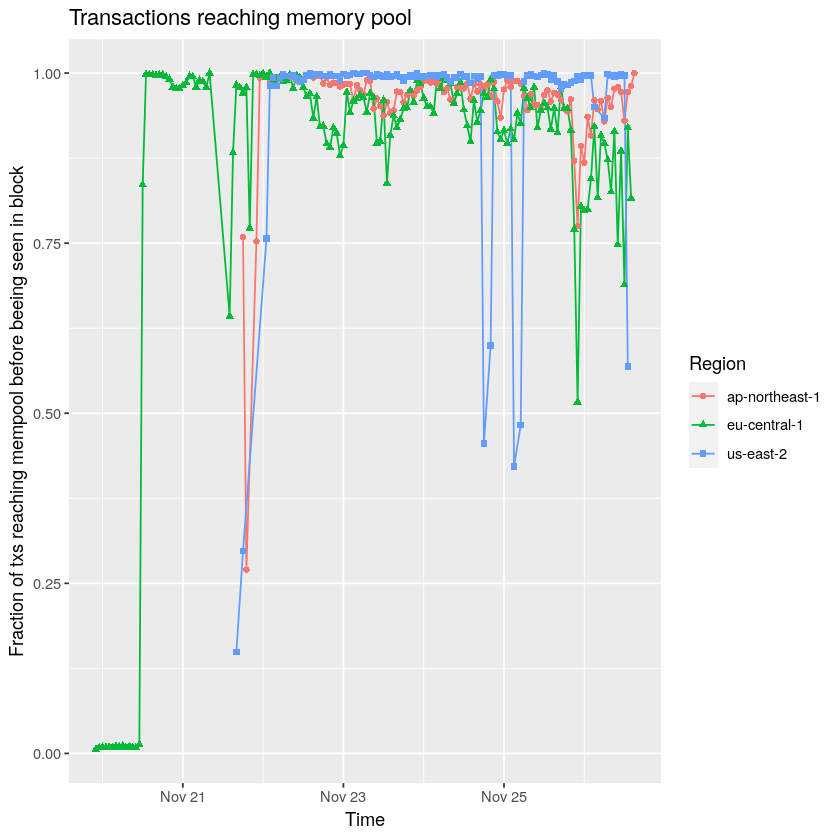

In [3]:
ggplot(mempoolHourly[`Tx first seen` == TRUE], aes(x=`Time`, y=`Tx fraction`, color=`Region`, shape=`Region`)) +
    geom_line() +
    geom_point() +
    ylab("Fraction of txs reaching mempool before beeing seen in block") +
    ggtitle(
        "Transactions reaching memory pool"
    )

In [4]:
ggsave("mempool-hourly.png", units="in", dpi=150, width=8, height=6)

## Mempool history

In [5]:
mempoolHistory <- fread("mempool-history.tsv.gz", stringsAsFactors=TRUE)
colnames(mempoolHistory) <- c("Region", "Slot", "Tx seen first", "Tx count")
mempoolHistory %>% summary

            Region           Slot           Tx seen first      Tx count      
 ap-northeast-1:19710   Min.   :172020832   Mode :logical   Min.   :  1.000  
 eu-central-1  :25266   1st Qu.:172257848   FALSE:10241     1st Qu.:  2.000  
 us-east-2     :18666   Median :172376257   TRUE :53401     Median :  5.000  
                        Mean   :172367517                   Mean   :  7.425  
                        3rd Qu.:172492659                   3rd Qu.: 10.000  
                        Max.   :172602993                   Max.   :122.000  

In [6]:
mempoolHistory[, `Tx fraction` := as.numeric(`Tx count`) / sum(`Tx count`), by =.(`Region`, `Slot`)]

### Histogram of slot-by-slot fraction of transactions preceding the block (nonlinear scale)

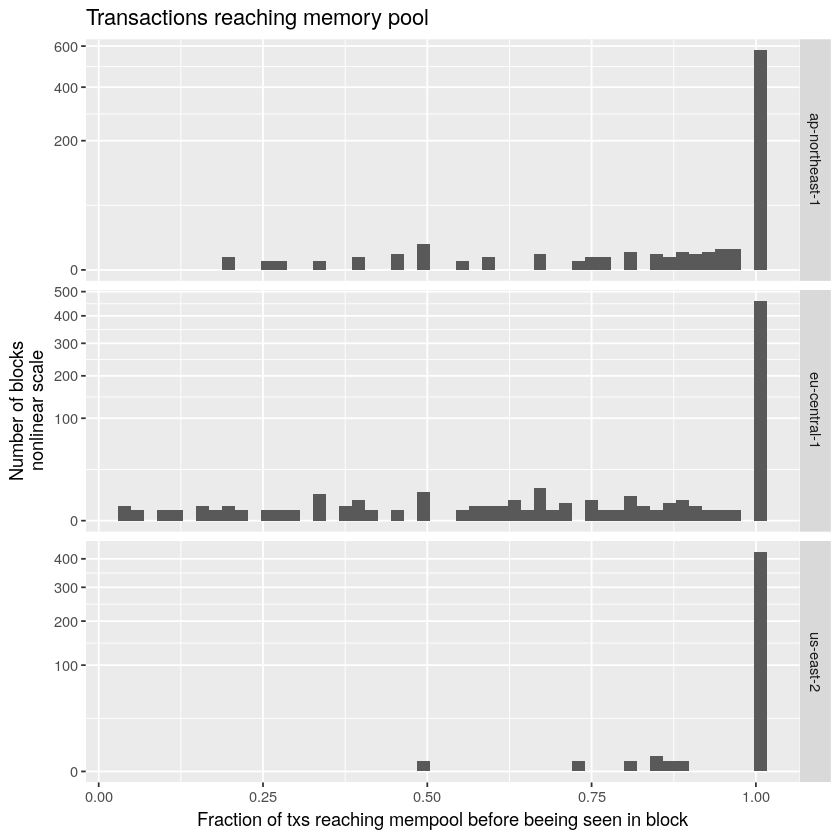

In [7]:
ggplot(mempoolHistory[`Slot` >= mempoolHistory[, max(`Slot`)] - 4 * 3600 & `Tx seen first` == TRUE], aes(x=`Tx fraction`)) +
    geom_histogram(bins=50) +
    scale_y_sqrt() +
    facet_grid(`Region` ~ ., scales="free_y") +
    xlab("Fraction of txs reaching mempool before beeing seen in block") +
    ylab("Number of blocks\nnonlinear scale") +
    ggtitle(
        "Transactions reaching memory pool"
    )

### Histogram of slot-by-slot fraction of transactions preceding the block

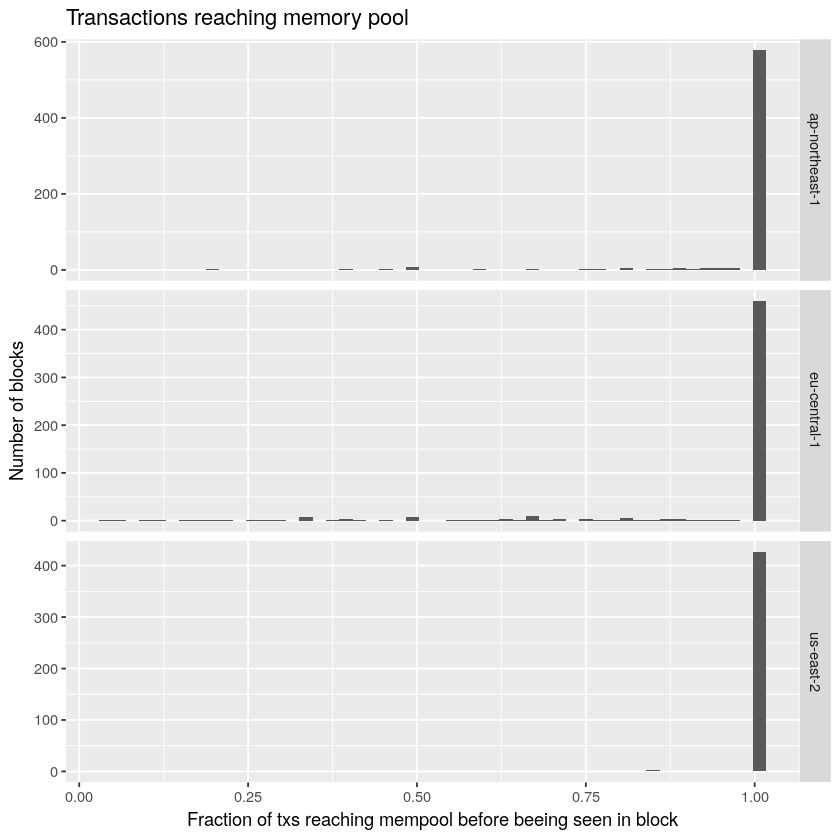

In [8]:
ggplot(mempoolHistory[`Slot` >= mempoolHistory[, max(`Slot`)] - 4 * 3600 & `Tx seen first` == TRUE], aes(x=`Tx fraction`)) +
    geom_histogram(bins=50) +
    facet_grid(`Region` ~ ., scales="free_y") +
    xlab("Fraction of txs reaching mempool before beeing seen in block") +
    ylab("Number of blocks") +
    ggtitle(
        "Transactions reaching memory pool"
    )

In [9]:
ggsave("mempool-history.png", units="in", dpi=150, width=8, height=6)

## Mempool vs blocks

In [10]:
mempoolBlocks <- fread("mempool-vs-blocks.tsv.gz", stringsAsFactors=TRUE)
colnames(mempoolBlocks) <- c("Region", "Slot", "Block hash", "Tx hash", "Tx hash8", "Slot time", "Block logged", "Tx logged", "Mempool - slot time [s]", "Block - slot time [s]", "Tx seen first")
mempoolBlocks %>% summary

            Region            Slot          
 ap-northeast-1:141172   Min.   :172020832  
 eu-central-1  :191057   1st Qu.:172239440  
 us-east-2     :140292   Median :172372853  
                         Mean   :172359242  
                         3rd Qu.:172484977  
                         Max.   :172602993  
                                            
                                                            Block hash    
 4b9b817fb2ebd0959b7d31decc8225f6c4de874c2359706c327753c3961f4cc9:   237  
 b7dd177e8bf0ad0a52d41b1747bfde10b329ff4167bb408a5d7fef2735248e03:   234  
 90ab0197e16e39cf5af31bd1d193151f3582a2bee468ea953987e4b1c59de280:   224  
 b04ba46586aef364000ee0e42fa5fba6cdfae2294950e1ffb6c7fa2059fb7460:   222  
 9df8b4b6540b29d644074144490c0abb76d49ca62e11f9d4822ed1e0b6f8c0b2:   216  
 007e315be01f4cfb74e3c1c95f664aca16bf461be4cae4fe6e78e783896ea0b1:   201  
 (Other)                                                         :471187  
                                        

### Histogram of transaction arrival time relative to slot

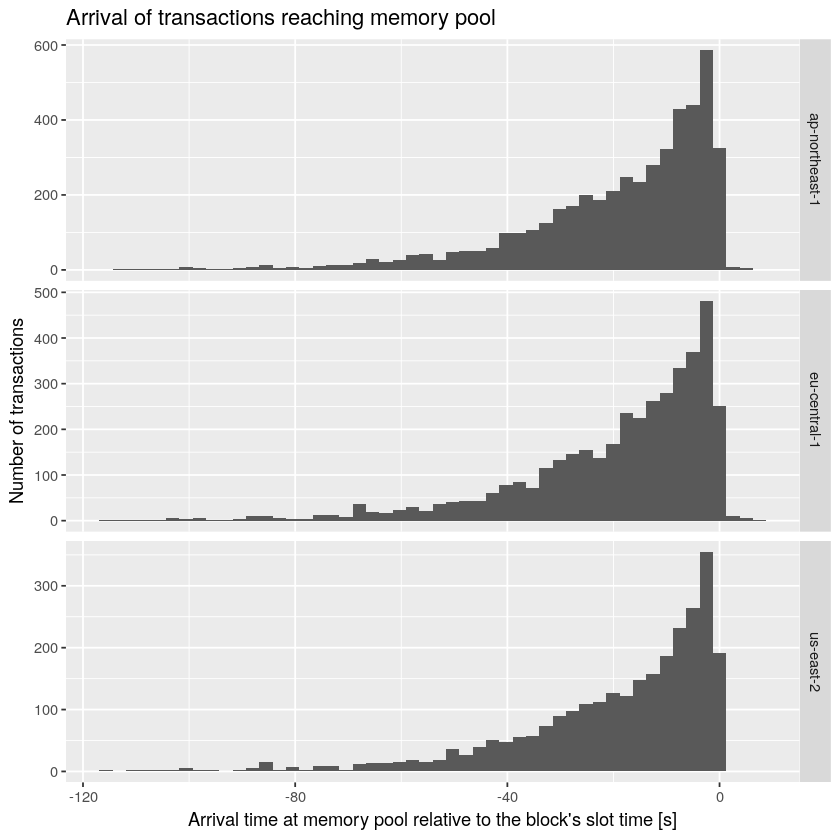

In [11]:
ggplot(mempoolBlocks[`Slot` >= mempoolHistory[, max(`Slot`)] - 4 * 3600  & `Tx seen first` == TRUE], aes(x=`Mempool - slot time [s]`)) +
    geom_histogram(bins=50) +
    facet_grid(`Region` ~ ., scales="free_y") +
    xlab("Arrival time at memory pool relative to the block's slot time [s]") +
    ylab("Number of transactions") +
    ggtitle(
        "Arrival of transactions reaching memory pool"
    )

In [12]:
ggsave("transaction-arrival.png", units="in", dpi=150, width=8, height=6)

### Histogram of block arrival time relative to slot

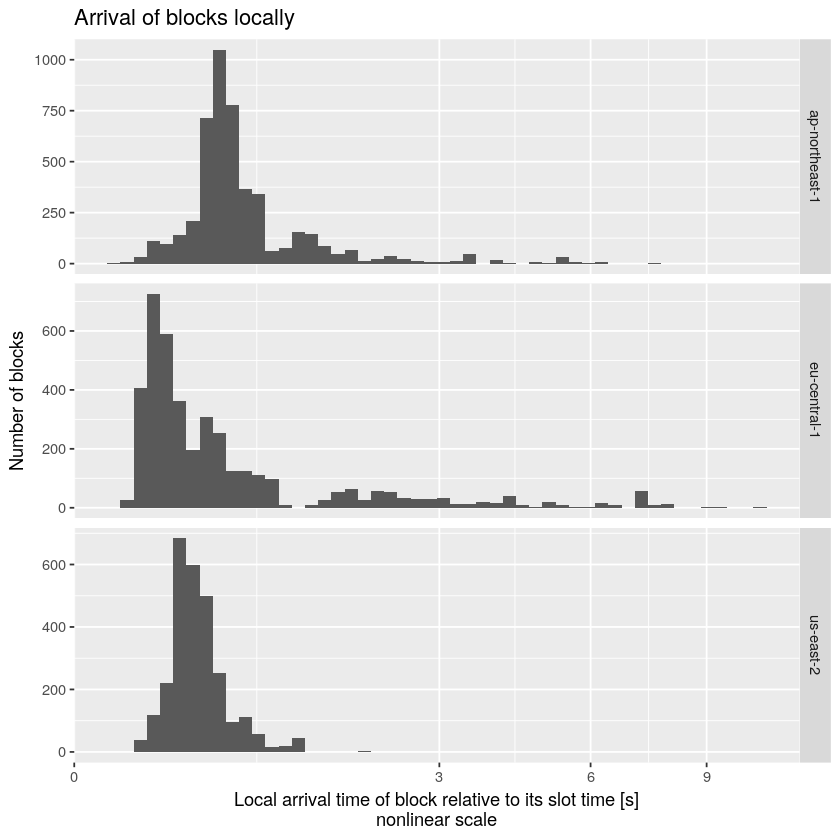

In [13]:
ggplot(mempoolBlocks[`Slot` >= mempoolHistory[, max(`Slot`)] - 4 * 3600 & `Tx seen first` == TRUE], aes(x=`Block - slot time [s]`)) +
    geom_histogram(bins=50) +
    facet_grid(`Region` ~ ., scales="free_y") +
    scale_x_sqrt() +
    xlab("Local arrival time of block relative to its slot time [s]\nnonlinear scale") +
    ylab("Number of blocks") +
    ggtitle(
        "Arrival of blocks locally"
    )

In [14]:
ggsave("block-arrival.png", units="in", dpi=150, width=8, height=6)